In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz')

data = data[data.detected_bool == 1]

In [6]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [7]:
object_ids = np.unique(data.object_id)

In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id]
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject['log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

# Visualization

In [13]:
def plot_light_curves(anobject, title=""):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 4))
    for passband in range(6):
        light_curve = get_passband(anobject, passband)
        plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

13.0


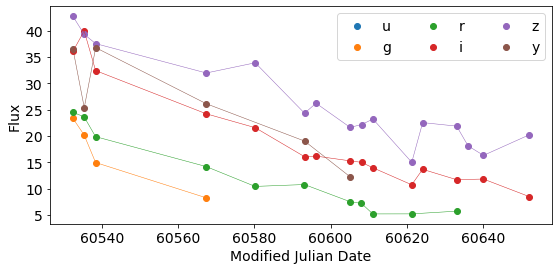

34.0


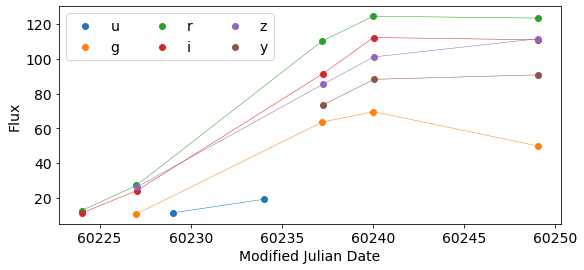

35.0


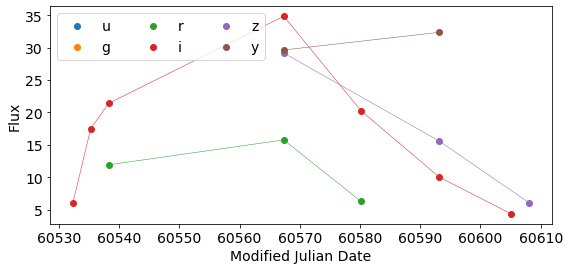

69.0


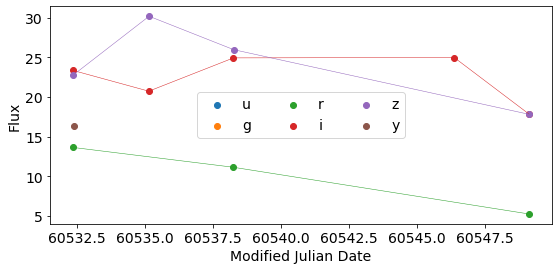

88.0


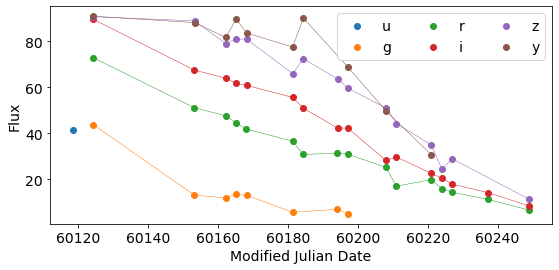

In [15]:
for i in object_ids[:5]:
    anobject = get_object(data, i)
    print(i)
    plot_light_curves(anobject)
    plt.show()

In [16]:
def get_time_range(i):
    
    # get an object
    anobject = get_object(data, i)
    
    # take only good curves
    if not is_good(anobject): 
        return -1
    
    # train test split
    t = anobject['mjd'].values
    t_range = t.max() - t.min()
    
    return t_range

In [17]:
%%time

t_range = Parallel(n_jobs=-1)(delayed(get_time_range)(i) for i in object_ids)
t_range = np.array(t_range)

CPU times: user 1min 20s, sys: 9.14 s, total: 1min 29s
Wall time: 2min 51s


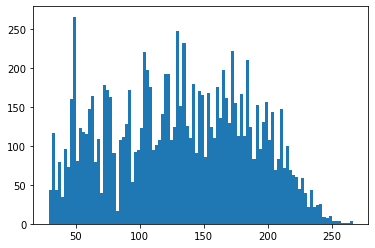

In [18]:
plt.hist(t_range[t_range != -1], bins=100)
plt.show()

# One object test Test

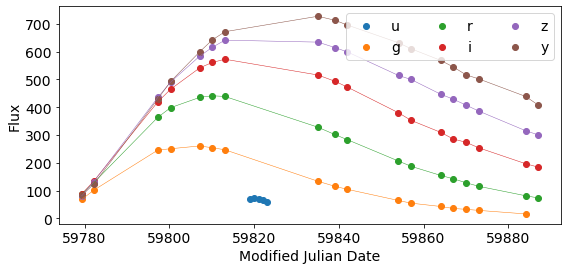

In [19]:
anobject = get_object(data, 34299) # 34299, 329277
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

RMSE:  2.571867032367581
MAE:  2.2367619479261274
RSE:  0.013177615251235569
RAE:  0.01293046817806452
MAPE:  1.6128692288125879
NLPD:  2.49867406332537
nRMSEo:  1.0770855049770023
nRMSEp:  0.6560319283643539
PICP@68:  0.9
PICP@95:  1.0


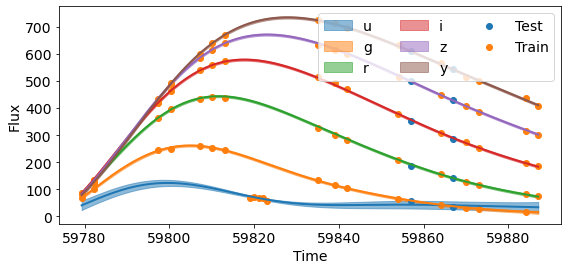

In [20]:
# train test split
t = anobject['mjd'].values
anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=5, 
                                                        test_size=2, 
                                                        shuffle=True, 
                                                        random_state=42, 
                                                        bounds_in_train=True)


t_train = anobject_train['mjd'].values
flux_train = anobject_train['flux'].values
flux_err_train = anobject_train['flux_err'].values
passband_train = anobject_train['passband'].values

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t_train, flux_train, flux_err_train, passband_train)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

# calculate quality metrics
flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
[rmse, mae, rse, rae, mape, nlpd, nrmseo, nrmsep, picp_68, picp_95] = utils.regression_quality_metrics_report(flux_test, flux_pred_test, 
                                                                                                              flux_err_test, flux_err_pred_test)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("NLPD: ", nlpd)
print("nRMSEo: ", nrmseo)
print("nRMSEp: ", nrmsep)
print("PICP@68: ", picp_68)
print("PICP@95: ", picp_95)

# Test on many objects

In [21]:
def gen_report(metrics, silent=False):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'NLPD', 'nRMSEo', 'nRMSEp', 'PICP_68', 'PICP_95'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    n_failed = report[report.MAE == -999].shape[0]
    if not silent: print("Num. of failed curves: ", n_failed)
    report = report[report.MAE != -999]
    return report

In [22]:
from sklearn.utils import resample

def bootstrap_metrics(metrics, n_iters=1000):
    means = []
    header = metrics.columns
    inds = np.arange(len(metrics))
    for i in range(n_iters):
        inds_boot = resample(inds)
        metrics_boot = metrics.iloc[inds_boot]
        means.append(metrics_boot.mean(axis=0))
    means = np.array(means)
    mu = np.round(means.mean(axis=0), 3)
    sigma = np.round(means.std(axis=0), 3)
    df = pd.DataFrame(columns=header, data=[mu, sigma], index=['mean', 'std'])
    return df

In [23]:
def one_object_run(i):
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    if not is_good(anobject): 
        return None
    
    # train test split
    t = anobject['mjd'].values
    try:
        anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                            t=t, 
                                                            bin_size=5, 
                                                            test_size=2, 
                                                            shuffle=True, 
                                                            random_state=42, 
                                                            bounds_in_train=True)
    
    except:
        print(i, len(anobject), t.max()-t.min())
        return [-999] * 10

    t_train = anobject_train['mjd'].values
    flux_train = anobject_train['flux'].values
    flux_err_train = anobject_train['flux_err'].values
    passband_train = anobject_train['passband'].values

    t_test = anobject_test['mjd'].values
    flux_test = anobject_test['flux'].values
    flux_err_test = anobject_test['flux_err'].values
    passband_test = anobject_test['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(passband2lam)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t_train, flux_train, flux_err_train, passband_train)

    # calculate quality metrics
    flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
    metrics = utils.regression_quality_metrics_report(flux_test, flux_pred_test, flux_err_test, flux_err_pred_test)
    
    return metrics

# Optimization

In [24]:
%%time

optim_sk = []

for layers in [(20, 20)]:
    for lr in [0.1, 0.01, 0.001]:
        for it in [90, 900]:
            for bz in [1, 500]:
                for wd in [0.1, 0.01, 0.001]:
                    
                    MODEL = "NN_sklearn"
                    params = {'passband2lam': passband2lam, 
                              'hidden_layer_sizes': layers,
                              'solver': 'lbfgs',
                              'activation': 'tanh',
                              'learning_rate_init': lr,
                              'max_iter': it,
                              'batch_size': bz, 
                              'weight_decay': wd}

                    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids[:1000])
                    report = gen_report(metrics, True)
                    optim_sk.append((params, report.mean()))
                
mape = np.array([m[1]['MAPE'] for m in optim_sk])
optim_sk[mape.argmin()]

CPU times: user 1min 12s, sys: 14.2 s, total: 1min 27s
Wall time: 3min 57s


({'passband2lam': {0: 3.5741887433059767,
   1: 3.675928577911155,
   2: 3.790512458057345,
   3: 3.875155060870028,
   4: 3.938479195804949,
   5: 3.987287656088505},
  'hidden_layer_sizes': (20, 20),
  'solver': 'lbfgs',
  'activation': 'tanh',
  'learning_rate_init': 0.1,
  'max_iter': 900,
  'batch_size': 500,
  'weight_decay': 0.1},
 ID         501.832461
 RMSE         8.606692
 MAE          6.703330
 RSE          0.608247
 RAE          0.594835
 MAPE        17.310278
 NLPD         9.912354
 nRMSEo       4.149998
 nRMSEp       2.743390
 PICP_68      0.474119
 PICP_95      0.691302
 dtype: float64)

In [25]:
%%time

optim_pt = []

for n_epochs in [100]:
    for lr in [0.1, 0.01, 0.001]:
        for bz in [1, 500]:
            for wd in [0.1, 0.01, 0.001]:

                MODEL = "NN_pytorch"
                params = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'activation': 'tanh', 
                          'n_epochs': n_epochs, 
                          'batch_size': bz, 
                          'lr': lr, 
                          'optimizer': 'Adam', 
                          'device': 'auto', 
                          'weight_decay': wd}

                metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids[:1000])
                report = gen_report(metrics, True)
                optim_pt.append((params, report.mean()))
                
mape = np.array([m[1]['MAPE'] for m in optim_pt])
optim_pt[mape.argmin()]

CPU times: user 48.4 s, sys: 7.17 s, total: 55.6 s
Wall time: 9min 28s


({'passband2lam': {0: 3.5741887433059767,
   1: 3.675928577911155,
   2: 3.790512458057345,
   3: 3.875155060870028,
   4: 3.938479195804949,
   5: 3.987287656088505},
  'n_hidden': 20,
  'activation': 'tanh',
  'n_epochs': 100,
  'batch_size': 500,
  'lr': 0.1,
  'optimizer': 'Adam',
  'device': 'auto',
  'weight_decay': 0.001},
 ID         501.832461
 RMSE        11.253854
 MAE          8.737814
 RSE          0.663906
 RAE          0.641506
 MAPE        21.365459
 NLPD         9.930951
 nRMSEo       5.443970
 nRMSEp       2.700930
 PICP_68      0.480384
 PICP_95      0.693010
 dtype: float64)

In [26]:
%%time

optim_bn = []

for sigma in [0.5, 0.1]:
    for lr in [0.1, 0.01, 0.001]:
        for kl in [0.1, 0.01, 0.0001]:
            for wd in [0.1, 0.01, 0.001]:
                
                MODEL = "BNN"
                params = {'passband2lam': passband2lam, 
                          'n_hidden': 20, 
                          'prior_sigma': sigma, 
                          'n_epochs': 1000, 
                          'lr': lr, 
                          'kl_weight': kl, 
                          'optimizer': 'Adam', 
                          'device': 'cpu', 
                          'weight_decay': wd}

                metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids[:1000])
                report = gen_report(metrics, True)
                optim_bn.append((params, report.mean()))
                
mape = np.array([m[1]['MAPE'] for m in optim_bn])
optim_bn[mape.argmin()]

CPU times: user 3min 19s, sys: 25.2 s, total: 3min 44s
Wall time: 46min 26s


({'passband2lam': {0: 3.5741887433059767,
   1: 3.675928577911155,
   2: 3.790512458057345,
   3: 3.875155060870028,
   4: 3.938479195804949,
   5: 3.987287656088505},
  'n_hidden': 20,
  'prior_sigma': 0.1,
  'n_epochs': 1000,
  'lr': 0.01,
  'kl_weight': 0.0001,
  'optimizer': 'Adam',
  'device': 'cpu',
  'weight_decay': 0.001},
 ID         501.832461
 RMSE        14.486451
 MAE         11.841576
 RSE          0.809693
 RAE          0.804876
 MAPE        26.901349
 NLPD         6.570671
 nRMSEo       6.913644
 nRMSEp       2.172701
 PICP_68      0.497318
 PICP_95      0.721671
 dtype: float64)

In [27]:
%%time

optim_nf = []

for lr in [0.05, 0.01, 0.005, 0.001]:
    for it in [1000]:
        for bz in [500]:
            for wd in [0.1, 0.01, 0.001]:

                try:
                    MODEL = "NF"
                    params = {'passband2lam': passband2lam, 
                              'batch_size': bz, 
                              'n_epochs': it, 
                              'lr': lr, 
                              'device': 'cpu', 
                              'weight_decay': wd}

                    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids[:1000])
                    report = gen_report(metrics, True)
                    optim_nf.append((params, report.mean()))
                except:
                    print("Failure with params:")
                    print(params)
                
mape = np.array([m[1]['MAPE'] for m in optim_nf])
optim_nf[mape.argmin()]

CPU times: user 46.3 s, sys: 5.9 s, total: 52.2 s
Wall time: 45min 11s


({'passband2lam': {0: 3.5741887433059767,
   1: 3.675928577911155,
   2: 3.790512458057345,
   3: 3.875155060870028,
   4: 3.938479195804949,
   5: 3.987287656088505},
  'batch_size': 500,
  'n_epochs': 1000,
  'lr': 0.01,
  'device': 'cpu',
  'weight_decay': 0.01},
 ID         501.832461
 RMSE         9.926861
 MAE          7.694222
 RSE          0.596071
 RAE          0.567913
 MAPE        18.793112
 NLPD         5.508064
 nRMSEo       4.545870
 nRMSEp       1.733993
 PICP_68      0.589631
 PICP_95      0.832856
 dtype: float64)

# Final run

In [28]:
%%time

MODEL = "GP"
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_gp = gen_report(metrics)
bootstrap_metrics(report_gp)

Num. of failed curves:  14
CPU times: user 2min 17s, sys: 8.56 s, total: 2min 25s
Wall time: 5min 30s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61069.796,100.437,81.297,1.272,1.204,24.109,6.197,7.599,1.442,0.632,0.837
std,597.139,8.199,6.491,0.090,0.086,0.729,0.643,0.186,0.017,0.003,0.002


In [29]:
%%time

MODEL = "NN_sklearn"
params = {'passband2lam': passband2lam, 
          'hidden_layer_sizes': (20, 20),
          'solver': 'lbfgs',
          'activation': 'tanh',
          'learning_rate_init': 0.1,
          'max_iter': 900,
          'batch_size': 500, 
          'weight_decay': 0.1}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_sk = gen_report(metrics)
bootstrap_metrics(report_sk)

Num. of failed curves:  14
CPU times: user 2min 28s, sys: 9.18 s, total: 2min 37s
Wall time: 5min 46s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61045.037,95.312,76.397,1.154,1.073,17.893,20.083,6.417,3.326,0.456,0.654
std,604.390,9.032,7.014,0.113,0.099,0.217,2.316,0.116,0.047,0.003,0.003


In [30]:
%%time

MODEL = "NN_pytorch"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'activation': 'tanh', 
          'n_epochs': 100, 
          'batch_size': 500, 
          'lr': 0.1, 
          'optimizer': 'Adam', 
          'device': 'auto', 
          'weight_decay': 0.001}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_pt = gen_report(metrics)
bootstrap_metrics(report_pt)

Num. of failed curves:  14
CPU times: user 2min 14s, sys: 8.95 s, total: 2min 23s
Wall time: 4min 47s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61084.874,105.737,85.70,1.314,1.222,21.557,18.071,7.591,3.249,0.451,0.648
std,612.013,9.766,7.72,0.154,0.135,0.309,1.058,0.139,0.044,0.003,0.003


In [31]:
%%time

MODEL = "BNN"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'prior_sigma': 0.1, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'kl_weight': 0.0001, 
          'optimizer': 'Adam', 
          'device': 'cpu', 
          'weight_decay': 0.001}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bn = gen_report(metrics)
bootstrap_metrics(report_bn)

Num. of failed curves:  14
CPU times: user 5min 25s, sys: 19.8 s, total: 5min 45s
Wall time: 26min 45s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61069.300,115.161,94.372,1.621,1.505,26.386,7.845,9.058,2.042,0.519,0.737
std,606.469,8.879,7.030,0.252,0.203,0.332,0.202,0.144,0.019,0.003,0.003


In [32]:
%%time

MODEL = "NF"
params = {'passband2lam': passband2lam, 
          'batch_size': 500, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'device': 'cpu', 
          'weight_decay': 0.01}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_nf = gen_report(metrics)
bootstrap_metrics(report_nf)

Num. of failed curves:  14
CPU times: user 10min 10s, sys: 35.2 s, total: 10min 45s
Wall time: 1h 48min 48s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61047.372,99.743,77.795,1.103,1.029,18.466,10.943,6.471,2.050,0.563,0.808
std,586.400,10.197,7.616,0.099,0.093,0.284,0.712,0.131,0.033,0.003,0.003


# Additional tests

In [33]:
%%time

MODEL = "NN_sklearn"
params = {'passband2lam': passband2lam, 
          'hidden_layer_sizes': (20, 20),
          'solver': 'lbfgs',
          'activation': 'tanh',
          'learning_rate_init': 0.01,
          'max_iter': 90,
          'batch_size': 1, 
          'weight_decay': 0.1}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_sk2 = gen_report(metrics)
bootstrap_metrics(report_sk2)

Num. of failed curves:  14
CPU times: user 2min 14s, sys: 8.17 s, total: 2min 22s
Wall time: 4min 3s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61113.82,97.678,78.101,1.163,1.085,18.394,16.509,6.560,3.027,0.474,0.674
std,627.35,9.348,7.132,0.118,0.103,0.281,1.542,0.119,0.040,0.003,0.003


In [34]:
%%time

MODEL = "BNN"
params = {'passband2lam': passband2lam, 
          'n_hidden': 20, 
          'prior_sigma': 0.1, 
          'n_epochs': 1000, 
          'lr': 0.01, 
          'kl_weight': 0.0001, 
          'optimizer': 'Adam', 
          'device': 'cpu', 
          'weight_decay': 0.0}

metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i) for i in object_ids)
report_bn = gen_report(metrics)
bootstrap_metrics(report_bn)

Num. of failed curves:  14
CPU times: user 5min 19s, sys: 19.8 s, total: 5min 39s
Wall time: 25min 58s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61079.348,107.149,87.725,1.483,1.348,23.614,28.886,8.236,4.964,0.283,0.477
std,620.554,9.034,7.204,0.251,0.187,0.328,1.169,0.139,0.049,0.003,0.003
